# Refactor `merge_operator_data`

Tiffany Notes 5/19
i added a script that i think is more helpful for your operator data, like aggregating to the portfolio name / handling ntd stuff, then filtering to the most recent date and saving it out. that way, you can just pull that table in your notebook.
i also took a pass at removing what looked like entries in the yml that had duplicative data, so fingers crossed, the datasets created in https://github.com/cal-itp/data-analyses/blob/5cf1083a9cafdf6c1068258762b2f6c19d7ba377/gtfs_digest/aggregate_filter_operator_data.py will be what you can use directly in the notebook.

5/21
But one of the columns I thought was useful for operator grain was taking the mode of the sched_rt_category per date from route direction file, and then attaching it to the operator grain. That can be used for the yaml (both deploy to get your list of operators) and for detecting errors

Reread notes in 

In [1]:
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd

In [2]:
import _report_visuals_utils
import google.auth
import merge_operator_data
import viz_data_prep
from calitp_data_analysis.sql import to_snakecase
from IPython.display import HTML, Image, Markdown, display, display_html
from merge_data import PORTFOLIO_ORGANIZATIONS_DICT, merge_in_standardized_route_names
from segment_speed_utils import gtfs_schedule_wrangling, helpers, time_series_utils
from segment_speed_utils.project_vars import COMPILED_CACHED_VIEWS, PROJECT_CRS
from shared_utils import (
    catalog_utils,
    dask_utils,
    gtfs_utils_v2,
    portfolio_utils,
    publish_utils,
    rt_dates,
    rt_utils,
)
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

credentials, project = google.auth.default()

In [3]:
from omegaconf import OmegaConf

readable_dict = OmegaConf.load("readable2.yml")

In [4]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [5]:
analysis_date_list = rt_dates.y2025_dates

## Figure out what's happening with the shortest/longest route and percentile groups.
* Use ``["portfolio_organization_nanme", "service_date"]`` to find these metrics.
* If a `portfolio_organization_name` compromises of 2+ `schedule_gtfs_dataset_key` values, sometimes each of these `schedule_gtfs_dataset_key` values are updated at a different candence. As such, there will be two different service_dates worth of data displayed. 

In [6]:
# Comment out and leave this cell right below pandas
portfolio_name = "City and County of San Francisco"
# portfolio_name = "City of West Hollywood"

In [7]:
operator_routes = merge_operator_data.concatenate_operator_routes(
    analysis_date_list
).pipe(merge_operator_data.merge_in_standardized_route_names)

In [15]:
sf_only_og = operator_routes.loc[
    operator_routes.portfolio_organization_name == portfolio_name
]

In [9]:
most_recent_dates = publish_utils.filter_to_recent_date(
    df=sf_only_og,
    group_cols=[
        "portfolio_organization_name",
    ],
)

In [10]:
"""sf_only_og = pd.merge(
    sf_only_og,
    most_recent_dates,
    on=["portfolio_organization_name","service_date"],
    how="inner",
)"""

In [21]:
sf_only_og.service_date.value_counts()

2025-01-15    71
2025-02-12    70
2025-04-16    70
2025-03-12     1
Name: service_date, dtype: int64

### Shortest and Longest works so far.

In [16]:
shortest = (
    sf_only_og[sf_only_og["route_length_miles"].notna()]  # remove nulls for distance
    .groupby(
        ["portfolio_organization_name", "service_date"], group_keys=False, dropna=False
    )["route_length_miles"]
    .min()
    .reset_index()
    .assign(shortest_longest="shortest")
)

In [17]:
shortest

,portfolio_organization_name,service_date,route_length_miles,shortest_longest
0,City and County of San Francisco,2025-01-15,1.52,shortest
1,City and County of San Francisco,2025-02-12,1.52,shortest
2,City and County of San Francisco,2025-03-12,2.39,shortest
3,City and County of San Francisco,2025-04-16,1.52,shortest


In [22]:
longest = (
    sf_only_og[sf_only_og["route_length_miles"].notna()]  # remove nulls for distance
    .groupby(
        ["portfolio_organization_name", "service_date"], group_keys=False, dropna=False
    )["route_length_miles"]
    .max()
    .reset_index()
    .assign(shortest_longest="longest")
)

In [23]:
longest

,portfolio_organization_name,service_date,route_length_miles,shortest_longest
0,City and County of San Francisco,2025-01-15,23.14,longest
1,City and County of San Francisco,2025-02-12,23.14,longest
2,City and County of San Francisco,2025-03-12,2.39,longest
3,City and County of San Francisco,2025-04-16,23.14,longest


In [24]:
percentile_df = sf_only_og.assign(
        p25 = (sf_only_og.groupby(["portfolio_organization_name", "service_date"], group_keys=False, dropna=False)
               ["route_length_miles"]
               .transform(lambda x: x.quantile(0.25))
              ),
        p50 = (sf_only_og.groupby(["portfolio_organization_name", "service_date"], group_keys=False, dropna=False)
               ["route_length_miles"]
               .transform(lambda x: x.quantile(0.5))
              ),
        p75 = (sf_only_og.groupby(["portfolio_organization_name", "service_date"], group_keys=False, dropna=False)
               ["route_length_miles"]
               .transform(lambda x: x.quantile(0.75))
              ),
    )

In [32]:
percentile_df[
    [
        "portfolio_organization_name",
        "organization_name",
        "service_date",
        "route_id",
        "route_length_miles",
        "p25",
        "p50",
        "p75"
    ]
].sort_values(by = ["organization_name","service_date"])

,portfolio_organization_name,organization_name,service_date,route_id,route_length_miles,p25,p50,p75
6388,City and County of San Francisco,City and County of San Francisco,2025-01-15,1,5.75,5.29,7.03,8.96
6389,City and County of San Francisco,City and County of San Francisco,2025-01-15,12,6.43,5.29,7.03,8.96
6390,City and County of San Francisco,City and County of San Francisco,2025-01-15,14,7.80,5.29,7.03,8.96
6391,City and County of San Francisco,City and County of San Francisco,2025-01-15,14R,8.69,5.29,7.03,8.96
6392,City and County of San Francisco,City and County of San Francisco,2025-01-15,15,7.41,5.29,7.03,8.96
6393,City and County of San Francisco,City and County of San Francisco,2025-01-15,18,7.89,5.29,7.03,8.96
6394,City and County of San Francisco,City and County of San Francisco,2025-01-15,19,8.36,5.29,7.03,8.96
6395,City and County of San Francisco,City and County of San Francisco,2025-01-15,1X,5.88,5.29,7.03,8.96
6396,City and County of San Francisco,City and County of San Francisco,2025-01-15,2,3.54,5.29,7.03,8.96
6397,City and County of San Francisco,City and County of San Francisco,2025-01-15,21,3.27,5.29,7.03,8.96


In [51]:
percentile_df.p25.unique()

array([5.295 , 5.2775, 2.39  ])

In [52]:
percentile_df.p50.unique()

array([7.03 , 7.045, 7.075, 2.39 ])

In [53]:
percentile_df.p75.unique()

array([8.955 , 8.9575, 2.39  ])

In [37]:
percentile_df = percentile_df.assign(
        # Categorize each route's route_length_miles into a category
        percentile_categorized = percentile_df.apply(
            lambda x:
            "25th percentile" if x["route_length_miles"] <= x.p25 
            else "50th percentile" if (x["route_length_miles"] > x.p25 and x["route_length_miles"] <= x.p50) 
            else "< 75th percentile" if (x["route_length_miles"] > x.p50 and x["route_length_miles"] <= x.p75) 
            else "> 75th percentile", axis=1
        ),
    ).rename(columns = {"percentile_categorized": "route_length_miles_percentile"})

In [40]:
percentile_df[
    [
        "portfolio_organization_name",
        "organization_name",
        "service_date",
        "route_id",
        "route_length_miles",
        "route_length_miles_percentile",
    ]
].sort_values(by = ["organization_name","service_date"])

,portfolio_organization_name,organization_name,service_date,route_id,route_length_miles,route_length_miles_percentile
6388,City and County of San Francisco,City and County of San Francisco,2025-01-15,1,5.75,50th percentile
6389,City and County of San Francisco,City and County of San Francisco,2025-01-15,12,6.43,50th percentile
6390,City and County of San Francisco,City and County of San Francisco,2025-01-15,14,7.80,< 75th percentile
6391,City and County of San Francisco,City and County of San Francisco,2025-01-15,14R,8.69,< 75th percentile
6392,City and County of San Francisco,City and County of San Francisco,2025-01-15,15,7.41,< 75th percentile
6393,City and County of San Francisco,City and County of San Francisco,2025-01-15,18,7.89,< 75th percentile
6394,City and County of San Francisco,City and County of San Francisco,2025-01-15,19,8.36,< 75th percentile
6395,City and County of San Francisco,City and County of San Francisco,2025-01-15,1X,5.88,50th percentile
6396,City and County of San Francisco,City and County of San Francisco,2025-01-15,2,3.54,25th percentile
6397,City and County of San Francisco,City and County of San Francisco,2025-01-15,21,3.27,25th percentile


In [45]:
percentile_df.route_length_miles_percentile.unique()

array(['50th percentile', '< 75th percentile', '25th percentile',
       '> 75th percentile'], dtype=object)

In [41]:
percentile_df = percentile_df.assign(
        percentile_group = percentile_df.apply(
            lambda x: 
            merge_operator_data.get_percentile_description(x.route_length_miles_percentile, x.p25, x.p50, x.p75), 
            axis=1)
    )
    

In [46]:
percentile_df.percentile_group.nunique()

5

In [47]:
percentile_df.percentile_group.value_counts()

25th percentile (<= 5 miles)        54
76th percentile (>= 8.1 miles)      54
26-50th percentile (5.1-7 miles)    52
51-75th percentile (7.1-8 miles)    51
25th percentile (<= 2 miles)         1
Name: percentile_group, dtype: int64

In [50]:
percentile_df.loc[percentile_df.percentile_group == "25th percentile (<= 2 miles)"][
    [
        "portfolio_organization_name",
        "organization_name",
        "service_date",
        "route_id",
        "route_length_miles",
        "percentile_group",
    ]
]

,portfolio_organization_name,organization_name,service_date,route_id,route_length_miles,percentile_group
12911,City and County of San Francisco,City and County of San Francisco,2025-03-12,GGPS,2.39,25th percentile (<= 2 miles)


In [43]:
percentile_df[
    [
        "portfolio_organization_name",
        "organization_name",
        "service_date",
        "route_id",
        "route_length_miles",
        "percentile_group",
    ]
].sort_values(by = ["organization_name","service_date"])

,portfolio_organization_name,organization_name,service_date,route_id,route_length_miles,percentile_group
6388,City and County of San Francisco,City and County of San Francisco,2025-01-15,1,5.75,26-50th percentile (5.1-7 miles)
6389,City and County of San Francisco,City and County of San Francisco,2025-01-15,12,6.43,26-50th percentile (5.1-7 miles)
6390,City and County of San Francisco,City and County of San Francisco,2025-01-15,14,7.80,51-75th percentile (7.1-8 miles)
6391,City and County of San Francisco,City and County of San Francisco,2025-01-15,14R,8.69,51-75th percentile (7.1-8 miles)
6392,City and County of San Francisco,City and County of San Francisco,2025-01-15,15,7.41,51-75th percentile (7.1-8 miles)
6393,City and County of San Francisco,City and County of San Francisco,2025-01-15,18,7.89,51-75th percentile (7.1-8 miles)
6394,City and County of San Francisco,City and County of San Francisco,2025-01-15,19,8.36,51-75th percentile (7.1-8 miles)
6395,City and County of San Francisco,City and County of San Francisco,2025-01-15,1X,5.88,26-50th percentile (5.1-7 miles)
6396,City and County of San Francisco,City and County of San Francisco,2025-01-15,2,3.54,25th percentile (<= 5 miles)
6397,City and County of San Francisco,City and County of San Francisco,2025-01-15,21,3.27,25th percentile (<= 5 miles)


In [42]:
percentile_df.columns

Index(['shape_array_key', 'geometry', 'feed_key', 'schedule_gtfs_dataset_key',
       'route_id', 'direction_id', 'route_key', 'route_length',
       'route_length_miles', 'is_downtown_local', 'is_local', 'is_coverage',
       'is_rapid', 'is_express', 'is_rail', 'is_ferry',
       'organization_source_record_id', 'organization_name', 'service_date',
       'portfolio_organization_name', 'name', 'combined_name',
       'recent_combined_name', 'recent_route_id', 'p25', 'p50', 'p75',
       'route_length_miles_percentile', 'percentile_group'],
      dtype='object')

In [18]:
sf_only_func = sf_only_og.pipe(
    merge_operator_data.categorize_route_percentiles,
    ["portfolio_organization_name", "service_date"],
)

In [20]:
sf_only_func.loc[(sf_only_func.shortest_longest == "longest")|(sf_only_func.shortest_longest == "shortest")][
    [
        "schedule_gtfs_dataset_key",
        "service_date",
        "route_id",
        "shortest_longest",
        "route_length_miles",
        "route_length_miles_percentile",
    ]
].sort_values(by = ["service_date"])

,schedule_gtfs_dataset_key,service_date,route_id,shortest_longest,route_length_miles,route_length_miles_percentile
50,7cc0cb1871dfd558f11a2885c145d144,2025-01-15,91,longest,23.14,> 75th percentile
52,7cc0cb1871dfd558f11a2885c145d144,2025-01-15,CA,shortest,1.52,25th percentile
208,8fa99062694cb2eec80c647258cf70dd,2025-01-15,1,shortest,2.39,25th percentile
209,8fa99062694cb2eec80c647258cf70dd,2025-01-15,1,longest,2.39,25th percentile
121,7cc0cb1871dfd558f11a2885c145d144,2025-02-12,91,longest,23.14,> 75th percentile
123,7cc0cb1871dfd558f11a2885c145d144,2025-02-12,CA,shortest,1.52,25th percentile
210,e6230c3c190508921b7f350020e82ed5,2025-02-12,GGPS,shortest,2.39,25th percentile
211,e6230c3c190508921b7f350020e82ed5,2025-02-12,GGPS,longest,2.39,25th percentile
212,e6230c3c190508921b7f350020e82ed5,2025-03-12,GGPS,shortest,2.39,25th percentile
213,e6230c3c190508921b7f350020e82ed5,2025-03-12,GGPS,longest,2.39,25th percentile


## Add `sched_rt_category` per date from `route direction file` to `merge_operator_data`
* Use SF the test case.

In [ ]:
def add_sched_rt_category() -> pd.DataFrame:
    """
    Add sched_rt_category to OPERATOR_PROFILE
    """
    FILE = GTFS_DATA_DICT.digest_tables.route_schedule_vp
    sched_rt_df = pd.read_parquet(f"{RT_SCHED_GCS}{FILE}.parquet")[
        [
            "service_date",
            "portfolio_organization_name",
            "sched_rt_category",
        ]
    ]

    sched_rt_df["sort"] = sched_rt_df["sched_rt_category"].map(
        {"schedule_and_vp": 3, "schedule_only": 2, "vp_only": 1}
    )

    # Sort and drop duplicates
    sched_rt_df2 = (
        (
            sched_rt_df.sort_values(
                by=["portfolio_organization_name", "service_date", "sort"],
                ascending=[True, True, False],
            ).drop_duplicates(subset=["portfolio_organization_name", "service_date"])
        )
        .reset_index(drop=True)
        .drop(columns=["sort"])
    )

    return sched_rt_df2

## Recreate old charts and maps `aggregate_filter_operator_dates.py`
* Use `operator_profiles_recent.parquet` and `operator_routes.parquet`
* Use <i>Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)</i>

In [ ]:
OPERATOR_PROFILE = GTFS_DATA_DICT.digest_tables.operator_profiles

In [ ]:
f"{RT_SCHED_GCS}{OPERATOR_PROFILE}_recent.parquet"

In [ ]:
op_profile_ntd = pd.read_parquet(f"{RT_SCHED_GCS}{OPERATOR_PROFILE}_recent.parquet")

In [ ]:
op_profile_ntd.service_date.unique()

In [ ]:
portfolio_name = "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"

In [ ]:
ventura_op_profile = op_profile_ntd.loc[
    (
        op_profile_ntd.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [ ]:
ventura_op_profile.columns

### Add this to `aggregate_filter_operator_data`

In [ ]:
def grab_most_recent_geography() -> gpd.GeoDataFrame:
    OPERATOR_ROUTE = GTFS_DATA_DICT.digest_tables.operator_routes_map

    op_geography_df = gpd.read_parquet(
        f"{RT_SCHED_GCS}{OPERATOR_ROUTE}.parquet",
        storage_options={"token": credentials.token},
    )

    most_recent_dates = publish_utils.filter_to_recent_date(
        df=op_geography_df, group_cols=["portfolio_organization_name", "route_id"]
    )

    most_recent_geo = pd.merge(
        op_geography_df,
        most_recent_dates,
        on=["route_id", "portfolio_organization_name", "service_date"],
        how="inner",
    )
    return most_recent_geo

In [ ]:
recent_geo = grab_most_recent_geography()

In [ ]:
ventura_geo = recent_geo.loc[
    (
        recent_geo.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [ ]:
try:
    date = ventura_op_profile["service_date"].dt.to_pydatetime()[0]
except:
    pass

In [ ]:
date

In [ ]:
service_area = int(ventura_op_profile.service_area_sq_miles.values[0])
service_area = "{:,}".format(service_area)
service_pop = int(ventura_op_profile.service_area_pop.values[0])
service_pop = "{:,}".format(service_pop)

In [ ]:
display(
    Markdown(
        f"""{portfolio_name} is headquartered in <b>{ventura_op_profile.hq_city.values[0]}</b> in the Urbanized Area of <b>{ventura_op_profile.primary_uza_name.values[0]}</b>.<br>
            This operator provides <b>{service_area}</b> square miles of public transit service, which has a service population of <b>{service_pop}</b>.<br>
            This organization is a {ventura_op_profile.reporter_type.values[0]}.<br>
            <b>Data Source</b>: <a href="https://www.transit.dot.gov/ntd/data-product/2022-annual-database-agency-information">National Transit Database</a> Annual Agency Information.
            """
    )
)

## Operator Overview

In [ ]:
try:
    display(
        Markdown(
            f"""The following data presents an overview of GTFS characteristics using data from the most recent date of
      <b>{date.strftime("%B")} {date.year}</b>."""
        )
    )
except:
    pass

In [ ]:
try:
    n_routes = ventura_op_profile["operator_n_routes"].values[0]
    n_routes = "{:,}".format(n_routes)
    display(
        Markdown(
            f"""{portfolio_name} runs <b>{n_routes}</b> unique routes. Below is the breakdown of the routes and routes can belong to one or more categories.<p>
            Route categories are determined using a approach that looks at GTFS trips data
        alongside National Association of City Transportation Officials (NACTO)'s
        <a href="https://nacto.org/publication/transit-street-design-guide/introduction/service-context/transit-route-types/">Transit Route Types</a> 
        and <a href= "https://nacto.org/publication/transit-street-design-guide/introduction/service-context/transit-frequency-volume/">Frequency and Volume</a>
        guides. Please see the <a href="https://github.com/cal-itp/data-analyses/blob/main/gtfs_digest/methodology.md">methodology docs</a> for more details on this approach.
        """
        )
    )
except:
    display(Markdown(f"""{portfolio_name} doesn't have an operator profile."""))

## Route Pie Chart

In [ ]:
def reshape_route_typology(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reshape dataframe to display
    route types in a pie chart.
    """
    route_type_cols = [
        "n_downtown_local_routes",
        "n_local_routes",
        "n_coverage_routes",
        "n_rapid_routes",
        "n_express_routes",
        "n_rail_routes",
        "n_ferry_routes",
    ]

    # Subset & transform.
    df2 = df[route_type_cols].T.reset_index()

    # Rename the columns in readable_dict area?
    df2.columns = ["Route Type", "Total Routes"]

    # Clean up values in Route Type
    # Use regex to remove 'n_' prefix and '_routes' suffix, and replace '_' with space
    df2["Route Type"] = (
        df2["Route Type"]
        .str.replace(r"^n_", "", regex=True)
        .str.replace("_", " ")
        .str.title()
    )

    return df2

In [ ]:
def route_typology_chart(df) -> alt.Chart:

    # Reshape dataframe from wide to long
    df2 = reshape_route_typology(df)

    specific_chart_dict = readable_dict.route_typology_graph

    chart = _report_visuals_utils.pie_chart(
        df=df2,
        color_col="Route Type",
        theta_col="Total Routes",
        color_scheme=[*specific_chart_dict.colors],
        tooltip_cols=[*specific_chart_dict.tooltip],
    ).properties(width=400, height=250)

    chart = chart.properties(title={"text": specific_chart_dict.title})
    return chart

In [ ]:
route_typology_chart(ventura_op_profile)

## Route Length Work
* `percentile_group` is only supposed to have 4 categories but there's 17

In [ ]:
try:
    n_service_miles = int(ventura_op_profile.operator_route_length_miles.values[0])
    n_service_miles = "{:,}".format(n_service_miles)
    display(
        Markdown(
            f"""{portfolio_name} provides <b>{n_service_miles}</b> miles of public transit.
        """
        )
    )

except:
    pass

## Percentile Groups

In [ ]:
OPERATOR_ROUTE = GTFS_DATA_DICT.digest_tables.operator_routes_map
op_geography_df = gpd.read_parquet(
    f"{RT_SCHED_GCS}{OPERATOR_ROUTE}.parquet",
    storage_options={"token": credentials.token},
)

In [ ]:
ventura_geo_og = op_geography_df.loc[
    (
        op_geography_df.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [ ]:
def reshape_percentile_groups(df: pd.DataFrame) -> pd.DataFrame:
    """
    Total number of routes by each
    the route_length_miles_percentile groups.
    """
    agg1 = (
        df.groupby(["percentile_group", "route_length_miles_percentile"])
        .agg({"route_id": "nunique"})
        .reset_index()
    ).rename(
        columns={"percentile_group": "Percentile Group", "route_id": "Total Routes"}
    )
    return agg1

In [ ]:
def percentile_routes_chart(df: pd.DataFrame) -> alt.Chart:

    # Reshape the dataframe
    agg1 = reshape_percentile_groups(df)

    specific_chart_dict = readable_dict.route_percentiles

    chart = _report_visuals_utils.bar_chart(
        x_col="Total Routes",
        y_col="Percentile Group",
        color_col="Percentile Group",
        color_scheme=[*specific_chart_dict.colors],
        tooltip_cols=[*specific_chart_dict.tooltip],
        date_format="",
    )

    chart = alt.layer(chart, data=agg1).properties(width=400, height=150)

    chart = chart.properties(
        title={
            "text": f"{specific_chart_dict.title}",
            "subtitle": specific_chart_dict.subtitle,
        }
    )
    return chart

In [ ]:
percentile_routes_chart(ventura_geo_og)

## Longest/Shortest Route

In [ ]:
def reshape_longest_shortest_route(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter for only the longest and shortest route
    """
    df2 = df.loc[
        (df.shortest_longest == "shortest") | (df.shortest_longest == "longest")
    ][["route_length_miles", "route_id", "recent_combined_name"]]

    df2 = df2.drop_duplicates(subset=["route_length_miles"])

    df2.columns = df2.columns.str.title().str.replace("_", " ")
    return df2

In [ ]:
def shortest_longest_routes_chart(df: pd.DataFrame) -> alt.Chart:

    # Reshape dataframe for graphing
    df2 = reshape_longest_shortest_route(df)

    specific_chart_dict = readable_dict.longest_shortest_route

    chart = _report_visuals_utils.bar_chart(
        x_col="Route Length Miles",
        y_col="Recent Combined Name",
        color_col="Route Length Miles",
        color_scheme=[*specific_chart_dict.colors],
        tooltip_cols=[*specific_chart_dict.tooltip],
        date_format="",
    )

    chart = alt.layer(chart, data=df2).properties(width=400, height=150)

    chart = chart.properties(
        title={
            "text": f"{specific_chart_dict.title}",
            "subtitle": specific_chart_dict.subtitle,
        }
    )
    return chart

In [ ]:
shortest_longest_routes_chart(ventura_geo)

In [ ]:
stop

### Route Map
* Need to wrap it into a function, but where would I put this function?

In [ ]:
ventura_geo = ventura_geo.rename(
    columns={
        "recent_combined_name": "Route",
        "route_length_miles": "Route Length (Miles)",
    }
)

In [ ]:
try:
    display(
        ventura_geo[["Route", "Route Length (Miles)", "geometry"]].explore(
            "Route",
            cmap="Spectral",
            tiles="CartoDB positron",
            width=500,
            height=300,
            style_kwds={"weight": 3},
            legend=False,
            tooltip=["Route", "Route Length (Miles)"],
        )
    )
except:
    display(Markdown(f"""{portfolio_name} doesn't have an route geographies."""))

## Counties Served

In [ ]:
try:
    display(
        Markdown(
            f"{portfolio_name} provides public transit in {ventura_op_profile['counties_served'].values[0]} counties."
        )
    )
except:
    display(Markdown(f"""{portfolio_name} doesn't have an route geographies."""))

## Number of Stops
* Mean arrivals is gone.

In [ ]:
try:
    n_stops = int(ventura_op_profile["operator_n_stops"].values[0])
    n_stops = "{:,}".format(n_stops)

    n_arrivals = int(ventura_op_profile["operator_n_arrivals"].values[0])
    n_arrivals = "{:,}".format(n_arrivals)
    display(
        Markdown(
            f"""{portfolio_name} stops at <b>{n_stops}</b> unique stops, 
                totaling to <b>{n_arrivals}</b> arrivals.
            """
        )
    )
except:
    pass

## Work before vacation

In [ ]:
stop

In [ ]:
schedule_df = merge_operator_data.concatenate_schedule_operator_metrics(
    analysis_date_list
)

In [ ]:
schedule_df.head(2)

In [ ]:
rt_schedule_df = merge_operator_data.concatenate_rt_vs_schedule_operator_metrics(
    analysis_date_list
)

In [ ]:
rt_schedule_df.head(2)

In [ ]:
gdf = (
    merge_operator_data.concatenate_operator_routes(analysis_date_list)
    .pipe(merge_data.merge_in_standardized_route_names)
    .pipe(
        portfolio_utils.standardize_portfolio_organization_names,
        PORTFOLIO_ORGANIZATIONS_DICT,
    )
)

In [ ]:
gdf.columns

### Task #1: Aggregate `crosswalk` to `portfolio_organization_name`
* <i>Group by name-service_date-portfolio_organization_name to aggregate up to      portfolio_organization_name,because name indicates different feeds, so we want to sum those</i>. 
* AH: How do we account for situations when the different `organization_names` have different hq_cities, reporter_types, etc -> see Ventura County. we use these fields in this part of the portfolio. 
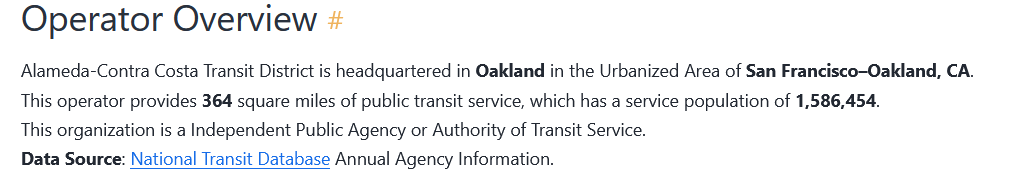

In [ ]:
crosswalk_df = merge_operator_data.concatenate_crosswalks(analysis_date_list)

In [ ]:
crosswalk_df.head(1)

In [ ]:
crosswalk_df.portfolio_organization_name.nunique(), len(
    crosswalk_df
), crosswalk_df.name.nunique()

In [ ]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"].shape

In [ ]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"][
    "portfolio_organization_name"
].nunique()

In [ ]:
crosswalk_df.loc[
    (crosswalk_df.service_date == "2024-01-17")
    & (
        crosswalk_df.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [ ]:
operator_df = merge_operator_data.merge_data_sources_by_operator(
    schedule_df, rt_schedule_df, crosswalk_df
)

In [ ]:
operator_df.head(1)

### Task #2: 
* Is there a short/long route, can it be flagged per date as a new column here?
* Piping the `portfolio_organization_name` goes at the end, 

In [ ]:
FILE = GTFS_DATA_DICT.schedule_tables.operator_routes

concatenate_schedule_operator_metrics_df = (
    time_series_utils.concatenate_datasets_across_dates(
        SCHED_GCS,
        FILE,
        analysis_date_list,
        data_type="gdf",
    )
    .sort_values(["schedule_gtfs_dataset_key", "service_date"])
    .reset_index(drop=True)
    .pipe(
        portfolio_utils.standardize_portfolio_organization_names,
        PORTFOLIO_ORGANIZATIONS_DICT,
    )
)

In [ ]:
concatenate_schedule_operator_metrics_df.columns

In [ ]:
concatenate_schedule_operator_metrics_df[["route_id", "route_key"]].sample(3)

In [ ]:
concatenate_schedule_operator_metrics_subset = concatenate_schedule_operator_metrics_df[
    [
        "portfolio_organization_name",
        "route_id",
        "route_length_miles",
        "service_date",
    ]
]

In [ ]:
len(concatenate_schedule_operator_metrics_subset), len(
    concatenate_schedule_operator_metrics_df
)

In [ ]:
concatenate_schedule_operator_metrics_subset = (
    concatenate_schedule_operator_metrics_subset.drop_duplicates()
)

In [ ]:
len(concatenate_schedule_operator_metrics_subset)

In [ ]:
def get_min_max(group):
    min_row = group.nsmallest(1, "route_length_miles").assign(
        long_short_route="shortest"
    )
    max_row = group.nlargest(1, "route_length_miles").assign(long_short_route="longest")
    return pd.concat([min_row, max_row])

In [ ]:
longest_shortest_route = (
    concatenate_schedule_operator_metrics_subset.groupby(
        ["service_date", "portfolio_organization_name"]
    )
    .apply(get_min_max)
    .drop(columns=["route_length_miles"])
    .reset_index(drop=True)
)

In [ ]:
len(longest_shortest_route)

In [ ]:
# longest_shortest_route.groupby(["service_date", "portfolio_organization_name"]).agg(
#    {"route_id": "nunique"}
# )

In [ ]:
longest_shortest_route.loc[
    longest_shortest_route.service_date == "2024-01-17"
].portfolio_organization_name.value_counts().head()

In [ ]:
longest_shortest_route.sample()

### Why are there extra rows popping up?

In [ ]:
#  Merge back with a left join
m1 = pd.merge(
    concatenate_schedule_operator_metrics_df,
    longest_shortest_route,
    on=["portfolio_organization_name", "route_id", "service_date"],
    how="outer",
    indicator=True,
)

In [ ]:
len(concatenate_schedule_operator_metrics_df)

In [ ]:
len(m1)

In [ ]:
m1._merge.value_counts()

In [ ]:
len(m1) - len(concatenate_schedule_operator_metrics_df)

In [ ]:
def find_percentiles(df: pd.DataFrame, col_of_interest: str) -> pd.DataFrame:
    """
    Take a column you're interested in and categorize it by row
    for each percentile group it belongs to.
    """
    # Get percentiles in objects for total vehicle.
    p25 = df[col_of_interest].quantile(0.25).astype(float)
    p50 = df[col_of_interest].quantile(0.50).astype(float)
    p75 = df[col_of_interest].quantile(0.75).astype(float)

    # Make a dataframe out of this
    percentile_data = {
        f"{col_of_interest}_percentile": [
            "25th percentile",
            "50th percentile",
            "< 75th percentile",
            "> 75th percentile",
        ],
        "percentile_group": [
            f"25 percentile (<={p25.astype(int)} miles)",
            f"26-50th percentile ({p25.astype(int) + 0.1}-{p50.astype(int)} miles)",
            f"51-75th percentile ({p50.astype(int) + 0.1}-{p75.astype(int)} miles)",
            f"76th percentile (>={p75.astype(int) + 0.1} miles)",
        ],
    }
    percentile_df = pd.DataFrame(data=percentile_data)

    def categorize_percentile(row):
        if (row[col_of_interest] > 0) and (row[col_of_interest] <= p25):
            return "25th percentile"
        elif (row[col_of_interest] > p25) and (row[col_of_interest] <= p50):
            return "50th percentile"
        elif (row[col_of_interest] > p50) and (row[col_of_interest] <= p75):
            return "< 75th percentile"
        elif row[col_of_interest] > p75:
            return "> 75th percentile"
        else:
            return "Zero"

    # Actually categorize each value for percentile
    df[f"{col_of_interest}_percentile"] = df.apply(
        lambda x: categorize_percentile(x), axis=1
    )

    # Delete out routes w/o service mile info
    df = df.loc[df[f"{col_of_interest}_percentile"] != "Zero"]

    # Merge the dataframes
    df2 = pd.merge(df, percentile_df, on=f"{col_of_interest}_percentile")
    return df2

In [ ]:
# Delete out nan route_length_miles
concatenate_schedule_operator_metrics_subset2 = (
    concatenate_schedule_operator_metrics_subset.loc[
        concatenate_schedule_operator_metrics_subset.route_length_miles.notna()
    ]
)

In [ ]:
len(concatenate_schedule_operator_metrics_subset2)

In [ ]:
percentile_df = pd.DataFrame()
for operator in list(
    concatenate_schedule_operator_metrics_subset2.portfolio_organization_name.unique()
):
    one_operator = concatenate_schedule_operator_metrics_subset2.loc[
        concatenate_schedule_operator_metrics_subset2.portfolio_organization_name
        == operator
    ]
    df = find_percentiles(one_operator, "route_length_miles")
    percentile_df = pd.concat([percentile_df, df], axis=0)

In [ ]:
len(percentile_df)

In [ ]:
percentile_df.sample(10)

In [ ]:
#  Merge back with a left join
m2 = pd.merge(
    m1,
    percentile_df.drop(columns=["route_length_miles", "route_length_miles_percentile"]),
    on=["portfolio_organization_name", "route_id", "service_date"],
    how="left",
)

In [ ]:
m2.shape

In [ ]:
m1.shape

In [ ]:
concatenate_schedule_operator_metrics_df.shape

In [ ]:
# percentile_df.groupby(["portfolio_organization_name", "percentile_group"]).agg({"route_id":"nunique"})

### Task #3: DONE.
* <i>take input produced in concatenate_operator_routes
    get counties for operator-date
    df should only be operator-date-counties_served
    use this to merge into crosswalk and replace NTD column</i>

In [ ]:
def get_counties() -> gpd.GeoDataFrame:
    """
    Load a geodataframe of the California counties.
    """
    ca_gdf = "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
    my_gdf = to_snakecase(gpd.read_file(f"{ca_gdf}"))[["county_name", "geometry"]]

    return my_gdf

In [ ]:
def counties_served_by_operator(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Join the geodataframe produced by concatenate_operator_routes
    to find which counties an operator serves.
    """
    # Subset
    gdf2 = gdf[["route_id", "service_date", "portfolio_organization_name", "geometry"]]

    # Grab counties
    ca_counties = get_counties()

    # Sjoin
    counties_served = gpd.sjoin(
        gdf2, ca_counties.to_crs(gdf.crs), how="inner", predicate="intersects"
    ).drop(columns="index_right")

    # Drop Duplicates
    counties_served2 = (
        counties_served[["service_date", "portfolio_organization_name", "county_name"]]
        .drop_duplicates()
        .sort_values(by=["county_name"])
        .reset_index(drop=True)
    )

    # Concatenate the counties using a groupby
    counties_served3 = counties_served2.groupby(
        [
            "service_date",
            "portfolio_organization_name",
        ],
        as_index=False,
    ).agg({"county_name": ",".join})

    return counties_served3

In [ ]:
counties_served_df = counties_served_by_operator(gdf)

In [ ]:
counties_served_df.head(2)

In [ ]:
crosswalk_df.sample()

In [ ]:
crosswalk_df2 = pd.merge(
    crosswalk_df,
    counties_served_df,
    how="outer",
    on=["portfolio_organization_name", "service_date"],
    indicator=True,
)

In [ ]:
crosswalk_df2._merge.value_counts()